#**Importing libraries**

In [1]:
import tensorflow as tf     #For Model
import numpy as np          #For Mathematical computation
import matplotlib.pyplot as plt             #For plotting charts and visualization
import tensorflow_datasets as tfds          #For loading the malaria dataset
import tensorflow_probability as tfp        #To calculate the Beta for the MixUp data augmentation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, Resizing, Rescaling, RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.losses import CategoricalCrossentropy                #To calculate loss of our model
from tensorflow.keras.optimizers import Adam                          #To use Adam as our model optimizer
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy   #To evaluate our model
import sklearn        #To import confusion matrix
from sklearn.metrics import confusion_matrix, roc_curve     #ROC to choose threshold more efficently
import seaborn as sns         #We use both seaborn and sklearn to plot confusion matrix for visualized model evaluation
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau     #Used to create our callback for better model performance
from tensorflow.keras.regularizers import L2, L1          #To Add regularization into out Conv2D layer
from tensorboard.plugins.hparams import api as hp
import os
#import wandb
#from wandb.keras import WandbMetricsLogger
from tensorflow.train import BytesList, FloatList, Int64List    #Feature types
from tensorflow.train import Example, Features, Feature         #To manage our protocol buffer

#**Downloading our Dataset from kaggle**

In [2]:
!pip install -q kaggle

In [3]:
!mkdir /.kaggle             #Create directory
!cp kaggle.json /.kaggle/   #Copy our json file in it

In [4]:
!chmod 600 /.kaggle/kaggle.json      #Give user full acces to read and write in it

In [5]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes    #Downloading Dataset from kaggle using API command

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 308M/309M [00:11<00:00, 31.3MB/s]
100% 309M/309M [00:11<00:00, 29.4MB/s]


In [6]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"    #Unzip the downloaded file and save it

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

#**Dataset Loading**

In [7]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]

#Configuring our model

CONFIGURATION = {
      "BATCH_SIZE" : 50,
      "IM_SIZE" : 256,
      "LEARNING_RATE": 0.001,
      "N_EPOCHS" : 20,
      "DROPOUT_RATE": 0.00,
      "REGULARIZATION_RATE" : 0.001,
      "N_FILTERS": 6,
      "KERNEL_SIZE": 3,
      "N_STRIDES" : 1,
      "POOL_SIZE": 2,
      "N_DENSE_1": 100,
      "N_DENSE_2": 10,
      "NUM_CLASSES": 3,
}

In [8]:
#Generate a tensorflow dataset based on the dataset we got

train_dataset = tf.keras.utils.image_dataset_from_directory(
          train_directory,
          labels = 'inferred',         #labels are generated from the directory structure
          label_mode = 'categorical',
          class_names = CLASS_NAMES,      #Class names must match the actual classes given in the dataset
          color_mode = 'rgb',
          batch_size = CONFIGURATION["BATCH_SIZE"],
          image_size = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
          shuffle = True,               #Automatic shuffling
          seed = 99
)

Found 6799 files belonging to 3 classes.


In [9]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
          val_directory,
          labels = 'inferred',         #labels are generated from the directory structure
          label_mode = 'categorical',
          class_names = CLASS_NAMES,      #Class names must match the actual classes given in the dataset
          color_mode = 'rgb',
          batch_size = CONFIGURATION["BATCH_SIZE"],
          image_size = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
          shuffle = True,               #Automatic shuffling
          seed = 99
)

Found 2278 files belonging to 3 classes.


#**Data Visualization**

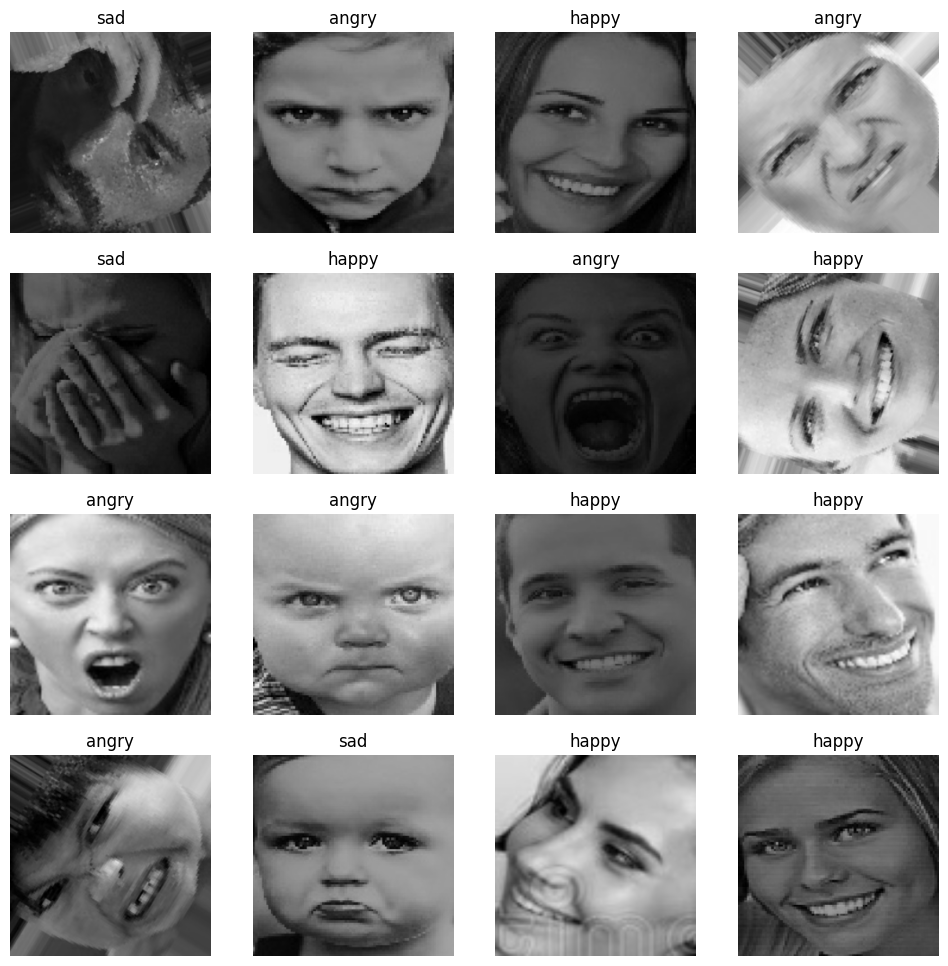

In [ ]:
plt.figure(figsize = (12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i] / 255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])    #Tf.argmax because our labels are one hot encoded
    plt.axis("off")

#**Data Augmentaion**

In [10]:
augment_layers = tf.keras.Sequential([           #implementing out data augmentaion as a keras layer
      RandomRotation(factor = (-0.025, 0.025)),       #limiting our rotation factor we faces in our dataset don't get rotated excessivly
      RandomFlip(mode = 'horizontal'),                #limiting from -9 degres to 9 degrees which is a normal face tilt (-0.025*360, 0.025*360)
      RandomContrast(factor = 0.1)
])


def augment_layer(image, label):                          #Takes the previous layer and outputs and augmented image and it's label
  return augment_layers(image, training = True), label

#**Dataset Preparation**

In [14]:
train_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    #.prefetch(tf.data.AUTOTUNE)   #for more efficent usage of our data         #We don't need prefetch when using tensorflow records
)

In [15]:
val_dataset = (
    val_dataset
    #.prefetch(tf.data.AUTOTUNE)   #for more efficent usage of our data
)

In [13]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255)
])

#**Tensorflow Records**

In [16]:
train_dataset = (
    train_dataset
    .unbatch()
)

In [17]:
val_dataset = (
    val_dataset
    .unbatch()
)

In [50]:
#implementing the Dict
def create_example(image, label):
  bytes_feature = Feature(                                       #Our images is the bytes feature
  bytes_list = BytesList(value = [image]))

  int_feature = Feature(                                        #Our labels is the int feature
    int64_list = Int64List(value = [label]))


  example = Example(                                        #Defining our Features for the example
    features = Features(feature = {
      'images': bytes_feature,
      'labels': int_feature
  }))

  return example.SerializeToString()

In [35]:
NUM_SHARDS = 10
PATH = '/content/tfrecords/shard_{:02d}.tfrecord'

In [45]:
#Change our images to bytes

def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype = tf.uint8)
  image = tf.io.encode_jpeg(image)

  return image, tf.argmax(label)

In [46]:
encoded_dataset = (
    train_dataset
    .map(encode_image)
)

In [ ]:
# Write the records to a file
for shard_number in range(NUM_SHARDS):          #Create a file for each shard (our data is separated into shards)

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:        #Write image and label in the file we created to store them
      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)


#**Modeling & Training**

In [11]:
model = tf.keras.Sequential([
              InputLayer(input_shape = (None, None, 3)),
              resize_rescale_layers,

              Conv2D(filters = CONFIGURATION["N_FILTERS"],
                     kernel_size = CONFIGURATION["KERNEL_SIZE"],
                     strides = CONFIGURATION["N_STRIDES"],
                     padding = 'valid',
                     activation = 'relu',
                     kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
              BatchNormalization(),
              MaxPool2D(pool_size = CONFIGURATION["POOL_SIZE"], strides = CONFIGURATION["N_STRIDES"]*2),
              Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

              Conv2D(filters = CONFIGURATION["N_FILTERS"]*3,
                     kernel_size = CONFIGURATION["KERNEL_SIZE"],
                     strides = CONFIGURATION["N_STRIDES"],
                     padding = 'valid',
                     activation = 'relu',
                     kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
              BatchNormalization(),
              MaxPool2D(pool_size = CONFIGURATION["POOL_SIZE"], strides = CONFIGURATION["N_STRIDES"]*2),

              Flatten(),                                            #Transform multidimensional tensors into 1D tensor

              Dense(CONFIGURATION["N_DENSE_1"], activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
              BatchNormalization(),
              Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

              Dense(CONFIGURATION["N_DENSE_2"], activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
              BatchNormalization(),


              Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax'),      #Using softmax because we got 3 classes in our dataset

])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 18)        │             990 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 18)        │              72 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 69192)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       6,919,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,922,037 (26.41 MB)

 Trainable params: 6,921,769 (26.40 MB)

 Non-trainable params: 268 (1.05 KB)

**Training**

In [12]:
#Using CategoricalCrossentropy where our labels mode are categorical and not int or binary
loss_function = CategoricalCrossentropy(
    from_logits = False                     #What's gonna get in this function is a logic tensor, and this is due to the softmax activation
)

metrics = [CategoricalAccuracy(name = "Accuracy"), TopKCategoricalAccuracy(k = 2, name = "top_k_accuracy")]
#We have to use categorical accuracy since we got 3 categorical classes and not binary

In [13]:
model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics
)

In [14]:
hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1
)

Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 102s 624ms/step - Accuracy: 0.4621 - loss: 1.5404 - top_k_accuracy: 0.7615 - val_Accuracy: 0.5105 - val_loss: 1.4219 - val_top_k_accuracy: 0.7739
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 115s 523ms/step - Accuracy: 0.6358 - loss: 1.1878 - top_k_accuracy: 0.8620 - val_Accuracy: 0.3494 - val_loss: 1.3997 - val_top_k_accuracy: 0.8011
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 69s 506ms/step - Accuracy: 0.6647 - loss: 1.0961 - top_k_accuracy: 0.8799 - val_Accuracy: 0.4947 - val_loss: 1.3093 - val_top_k_accuracy: 0.8455
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 69s 505ms/step - Accuracy: 0.6880 - loss: 1.0656 - top_k_accuracy: 0.8967 - val_Accuracy: 0.5672 - val_loss: 1.2566 - val_top_k_accuracy: 0.8406
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 71s 521ms/step - Accuracy: 0.7161 - loss: 1.0323 - top_k_accuracy: 0.9043 - val_Accuracy: 0.6651 - val_loss: 1.1723 - val_top_k_accuracy: 0.8806
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 70s 512ms/step - Accuracy: 0.7186

#**Plots**

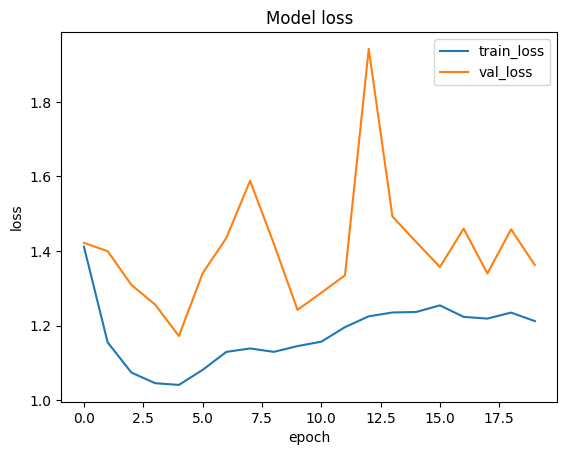

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

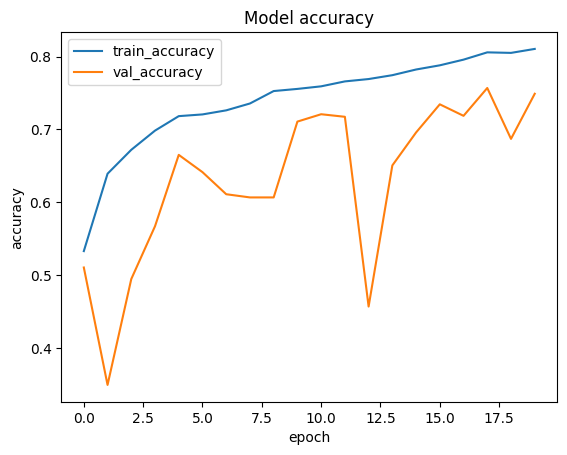

In [16]:
plt.plot(hist.history['Accuracy'])
plt.plot(hist.history['val_Accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

#**Evaluation**

In [17]:
model.evaluate(val_dataset)

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - Accuracy: 0.7451 - loss: 1.3804 - top_k_accuracy: 0.9190


[1.362342357635498, 0.7489025592803955, 0.9218612909317017]

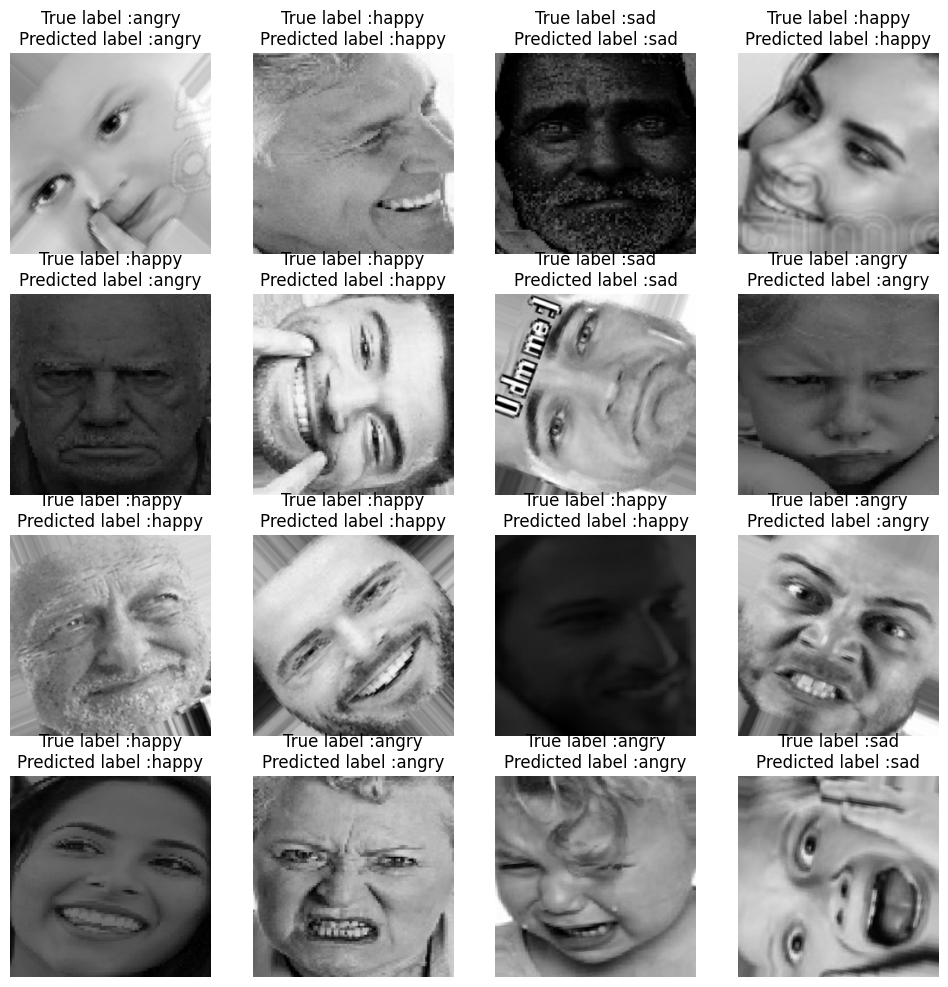

In [ ]:
plt.figure(figsize = (12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i] / 255.)
    plt.title("True label :" + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()] + "\n" + "Predicted label :" + CLASS_NAMES[tf.argmax(model(tf.expand_dims(images[i], axis = 0)), axis = -1 ).numpy()[0]])
    plt.axis("off")